## Import packages and load data

In [80]:
# Load packages
import scipy as sp
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, auc,roc_auc_score,roc_curve, accuracy_score
from sklearn.feature_selection import SelectFromModel
# import pandas_profiling

from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
# import matplotlib.style as style
# style.use('classic')

In [81]:
# Load data
# loan_data = pd.read_csv('Lending_Club_v2.csv', low_memory=False)
loan_data = pd.read_csv('loan_data_2007_2014.csv', low_memory=False)


In [82]:
# Check the data shape
loan_data.shape

(466285, 75)

#### Define target variable

In [83]:
# Define target variable and drop loan_status
bad_indicators = ["Charged Off ",
"Charged Off",
"Default",
"Does not meet the credit policy. Status:Charged Off",
"In Grace Period",
"Default Receiver",
"Late (16-30 days)",
"Late (31-120 days)"]
loan_data['target'] = loan_data['loan_status'].isin(bad_indicators).astype(int)
loan_data.drop('loan_status', axis =1, inplace = True)
df_eda = loan_data.copy()

We noticed very strict defination of bad borrowers.

In [84]:
# Check target variable value counts and percentage
print('Total number of records:\n', len(loan_data))
print('Number of records in each class:\n', loan_data['target'].value_counts())
print('Percentage in each class:\n', loan_data['target'].value_counts()/len(loan_data))

Total number of records:
 466285
Number of records in each class:
 0    410953
1     55332
Name: target, dtype: int64
Percentage in each class:
 0    0.881334
1    0.118666
Name: target, dtype: float64


There are 42542 records in total, and about 15.1% is defaulted or delinquent more than 16 days.   
The dataset has imbalance classes. xgboost performs well in general, even on imbalanced classification datasets. I will tune the training algorithm to pay more attention to misclassification of the minority class for datasets with a skewed class distribution.

## Data cleaning and feature reduction

#### Check mising values in columns

As we can see there are 42542 rows & 144 columns in the dataset, it will be very difficult to look at each column one by one & find the NA or missing values. So let's find out all columns where missing values are more than certain percentage, let's say 90%. We will remove those columns as it is not feasable to impute missing values for those columns.

In [85]:
pd.options.display.max_columns = None

In [86]:
# Percentage of null values in each column 
pd.options.display.max_rows = None
loan_data.isna().mean().sort_values(ascending = False)

annual_inc_joint               1.000000
verification_status_joint      1.000000
open_acc_6m                    1.000000
open_il_6m                     1.000000
open_il_12m                    1.000000
open_il_24m                    1.000000
mths_since_rcnt_il             1.000000
total_bal_il                   1.000000
il_util                        1.000000
open_rv_12m                    1.000000
open_rv_24m                    1.000000
max_bal_bc                     1.000000
all_util                       1.000000
inq_last_12m                   1.000000
inq_fi                         1.000000
total_cu_tl                    1.000000
dti_joint                      1.000000
mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
desc                           0.729815
mths_since_last_delinq         0.536906
next_pymnt_d                   0.487286
tot_coll_amt                   0.150715
total_rev_hi_lim               0.150715
tot_cur_bal                    0.150715


In [87]:
# -------------------------------------------------------------------------
def remove_nulls(data, axis = 1, percent = 0.75):
# Remove rows and columns based on parameters provided.
    df = data.copy()
    ishape = df.shape
    if axis == 0:
        rownames = (df.transpose().isnull().sum()/df.shape[1])
        rownames = list(rownames[rownames.values > percent].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

#### Remove columns where NA values are more than or equal to 90%

In [88]:
# Drop the columns with % of null value > 90%, to be conservative.
loan_data = remove_nulls(loan_data, axis = 1, percent = 0.9)

Number of Columns dropped	:  17

Old dataset rows,columns (466285, 75) 
New dataset rows,columns (466285, 58)


According to this criteria, 90 out of 144 columns were dropped.

#### Remove rows where NA values are more than or equal to 90%

In [89]:
# Drop the rows with % of null value > 90%, because the records cannot be reliable since too many features are missing.
loan_data = remove_nulls(loan_data, axis = 0, percent = 0.9)


Number of Rows dropped	:  0

Old dataset rows,columns (466285, 58) 
New dataset rows,columns (466285, 58)


According to this criteria, 7 rows were dropped.

#### Remove columns with one unique value and no missing values.   
if a variable only contains one value and no missing values, the variable does not have any predictive power.


In [90]:
# Let's look at # of unique values for each column.
# I will remove all columns where number of unique value is 1 
# Those columns will not give us any insights.
def remove_1unique(data):
    df = data.copy()
    ishape = df.shape
    uniques = df.nunique()
    unique = uniques[uniques.values == 1] 
    nomissings = df.isnull().sum()
    nomissing = nomissings[nomissings.values==0]
    df.drop(labels = list(nomissing.index.intersection(unique.index)), axis =1, inplace=True)
    print('Dropped columns:\n', list(unique.index))
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)
    
    
    return df

In [91]:
loan_data = remove_1unique(loan_data)

Dropped columns:
 ['policy_code', 'application_type']

Old dataset rows,columns (466285, 58) 
New dataset rows,columns (466285, 56)


Here we removed 7 columns with one unique and no missing values value because these columns don't contain any useful information. And I also double checnked the value it's contained.

#### Transform some characteristics variables into numeric

In [102]:
def del_str_process(data):
# Convert object column to numeric variable
#     data['term'] = data['term'].str.replace('months',' ').str.strip().astype('float64')
    data['int_rate'] = data['int_rate'] * 0.01
    data['revol_util'] = data['revol_util']* 0.01   
    data['emp_length'] = data['emp_length'].str.replace('< 1 year','0').str.replace('10+ years','10')
    data['emp_length'] = data['emp_length'].str.replace('n/a','-1').str.strip()
    data['emp_length'] = data['emp_length'].str.replace('years',' ').str.replace('year',' ').str.strip()
    data['emp_length'][data['emp_length'] == '10+'] = 10
    data['emp_length'] = data['emp_length'].astype('float64')   
    data['annual_inc'] = data['annual_inc'].astype('float64') 
    
    return data

In [98]:
loan_data.term.head()

0    36.0
1    60.0
2    36.0
3    36.0
4    60.0
Name: term, dtype: float64

In [103]:
loan_data = del_str_process(loan_data)

#### Handle datetime columns

In [104]:
def convert_date(data):
# Convert object column to datetime: last_pymnt_d, last_credit_pull_d, earliest_cr_line, issue_d
    data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'], format='%b-%y')
    data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'], format='%b-%y')
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')
    data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y')
    
    return data

In [105]:
loan_data = convert_date(loan_data) 

For all the datetime variable we don't have a reference date to calculate durations. So I decide to drop them.

In [106]:
loan_data.drop(columns = ['last_pymnt_d','last_credit_pull_d', 'earliest_cr_line', 'issue_d'], inplace = True)

#### Data Leakage Issue

The goal of predictive modeling is to develop a model that makes accurate predictions on new data, unseen during training.
A column is considered to leak information when the data it contains won’t be available when we use our model to make predictions, or — in this case when we use our model to predict whether a borrower will default.
Data leakage can cause you to create overly optimistic predictive models.
such as the 

In [107]:
# We can confirm our thoughts by checking a couple of variables. 
# When recoveries is greater than zero, it indicates the loan is already defaulted.
loan_data[loan_data['recoveries']>0]['target'].value_counts()

1    24371
Name: target, dtype: int64

In [108]:
loan_data[loan_data['collection_recovery_fee']>0]['target'].value_counts()

1    23206
Name: target, dtype: int64

To prevent using data about the target column that wouldn't be available when we're using the model on future loans, the following columns need to be removed:

**recoveries**: also leaks data from the future.   
**collection_recovery_fee**: also leaks data from the future.   
**total_rec_prncp**: also leaks data from the future.   
**total_rec_late_fee**: also leaks data from the future.    
**total_pymnt**: also leaks data from the future.   
**total_pymnt_inv**: also leaks data from the future.   
**debt_settlement_flag**: also leaks data from the future.


In [111]:
drop_list = [
'recoveries',
'collection_recovery_fee',
'total_rec_prncp',
'total_rec_late_fee',
'total_pymnt',
'total_pymnt_inv'
    ]

In [112]:
loan_data.drop(columns=drop_list, inplace = True)

#### Remove  columns not suitable for modeling

Now let's look at each column from business perspective if that is required or not for our analysis.   

In [113]:
loan_data[['title','emp_title']].nunique()

title         63099
emp_title    205475
dtype: int64

These two columns are high cardinality variables and not suitable for modeling, and we are going to drop them unless we find some business rationale to dig deep into the variables.

In [114]:
loan_data.drop(columns = ['title','emp_title'], inplace = True)

In [115]:
loan_data[['grade','sub_grade']].head()

,grade,sub_grade
0,B,B2
1,C,C4
2,C,C5
3,C,C1
4,B,B5


Since grade and sub_grade are correlated, and sub_grade contains more granular information, I will drop grade and convert sub_grade to numeric later.

In [116]:
loan_data.drop(columns = 'grade', inplace = True)

In [117]:
loan_data['zip_code'].head()

0    860xx
1    309xx
2    606xx
3    917xx
4    972xx
Name: zip_code, dtype: object

Mostly redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible. I will drop it.

In [118]:
loan_data.drop(columns = 'zip_code', inplace = True)

In [119]:
loan_data['desc'].head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

The desc column may require extensive NLP to gain insights. Due to time constraints, we will drop it as well. 

In [120]:
loan_data.drop(columns = 'desc', inplace = True)

## EDA

#### Check descriptive statistics

In [121]:
# Check the statistics of numeric variables
loan_data.select_dtypes(include='number').describe().round(1).transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,466285.0,233142.0,134605.0,0.0,116571.0,233142.0,349713.0,466284.0
id,466285.0,13079729.9,10893711.6,54734.0,3639987.0,10107897.0,20731209.0,38098114.0
member_id,466285.0,14597660.6,11682367.4,70473.0,4379705.0,11941075.0,23001541.0,40860827.0
loan_amnt,466285.0,14317.3,8286.5,500.0,8000.0,12000.0,20000.0,35000.0
funded_amnt,466285.0,14291.8,8274.4,500.0,8000.0,12000.0,20000.0,35000.0
funded_amnt_inv,466285.0,14222.3,8297.6,0.0,8000.0,12000.0,19950.0,35000.0
term,466285.0,42.6,10.7,36.0,36.0,36.0,60.0,60.0
int_rate,466285.0,0.1,0.0,0.1,0.1,0.1,0.2,0.3
installment,466285.0,432.1,243.5,15.7,256.7,379.9,566.6,1410.0
emp_length,445277.0,6.0,3.6,0.0,3.0,6.0,10.0,10.0


#### Loan Amount Distribuition

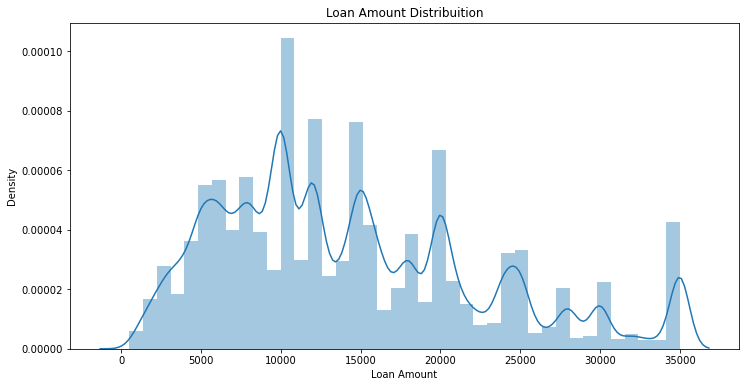

In [122]:
plt.figure(figsize=(12,6))
g = sns.distplot(loan_data["loan_amnt"],  bins = 40)
g.set_xlabel("Loan Amount")
g.set_ylabel("Density")
g.set_title("Loan Amount Distribuition")
plt.show()

We can note that a big part of the loans are values between 5,000 and 15,000 dollars;

#### Interest Rate Distribuition

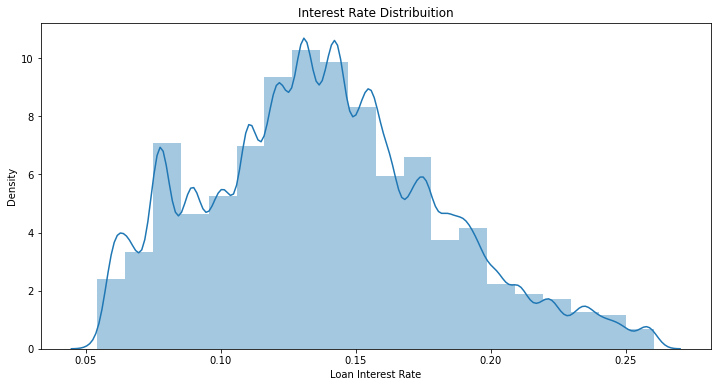

In [123]:
plt.figure(figsize=(12,6))
g = sns.distplot(loan_data["int_rate"].dropna(),  bins = 20)
g.set_xlabel("Loan Interest Rate")
g.set_ylabel("Density")
g.set_title("Interest Rate Distribuition")
plt.show()

Also, many part of all loans have interest between 6% and 16%, and the most common one is 11%.

#### Installment Distribuition

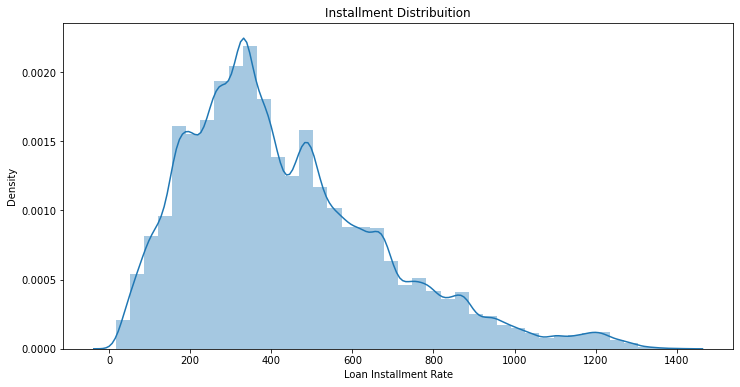

In [124]:
plt.figure(figsize=(12,6))
g = sns.distplot(loan_data["installment"],  bins = 40)
g.set_xlabel("Loan Installment Rate")
g.set_ylabel("Density")
g.set_title("Installment Distribuition")
plt.show()

We can see that the peak of our distribution is ~200 dollars monthly, and majority of the installment are less then 500 dollars.

#### Distributions of Interest Rate 

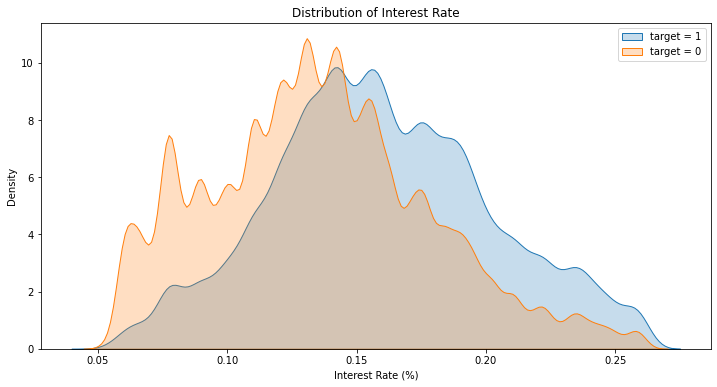

In [125]:
fig = plt.figure(figsize=(12,6))
sns.kdeplot(loan_data.loc[loan_data['target'] == 1, 'int_rate'], label = 'target = 1', shade=True)
sns.kdeplot(loan_data.loc[loan_data['target'] == 0, 'int_rate'], label = 'target = 0', shade=True);
plt.legend()
plt.xlabel('Interest Rate (%)')
plt.ylabel('Density')
plt.title('Distribution of Interest Rate');

The interest rate distributions of default and non-default show different patterns. It indicates borrowers with higher interest rates have high possibility to be default.

#### Check Home Ownership

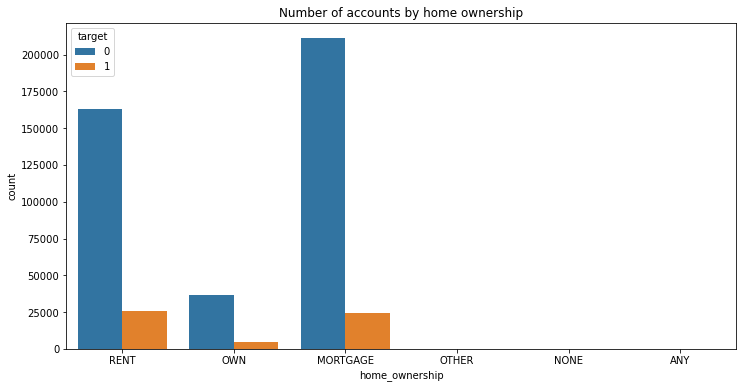

In [126]:
plt.figure(figsize=(12,6))
sns.countplot(data = loan_data, x = 'home_ownership', hue = 'target');
plt.title('Number of accounts by home ownership');

Most borrower live in rent home or have mortgage.

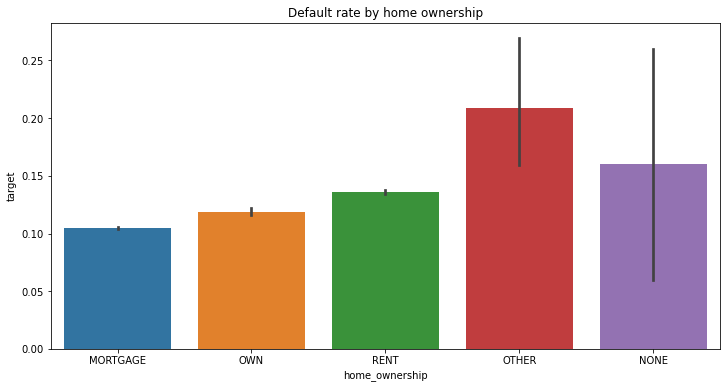

In [127]:
plt.figure(figsize=(12,6))
level_order = ['MORTGAGE', 'OWN', 'RENT', 'OTHER', 'NONE']
sns.barplot(x='home_ownership', order=level_order, y ='target', data = loan_data);
plt.title('Default rate by home ownership');

Home owners are less possible to be bad borrowers.

#### Check Loan Purpose

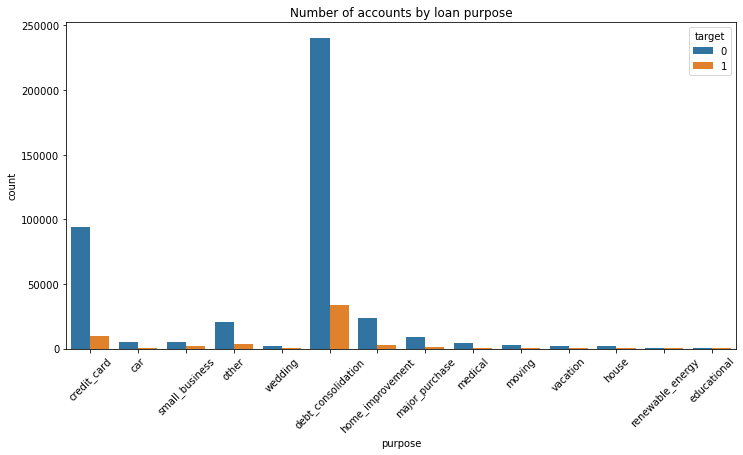

In [128]:
plt.figure(figsize=(12,6))
g = sns.countplot(data = loan_data, x = 'purpose', hue = 'target');
g.set_xticklabels(g.get_xticklabels(), rotation=45);
plt.title('Number of accounts by loan purpose');

The top 3 purposes are: Debt Consolidation, paying Credit Card and small business.

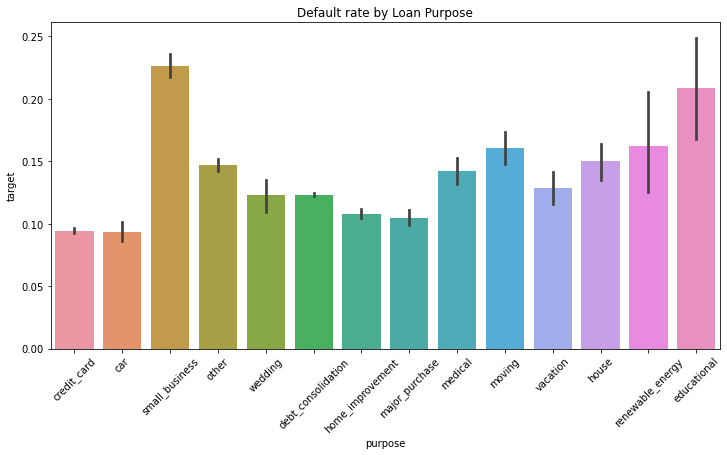

In [129]:
plt.figure(figsize=(12,6))
g = sns.barplot(x='purpose', y ='target', data = loan_data);
g.set_xticklabels(g.get_xticklabels(), rotation=45);
plt.title('Default rate by Loan Purpose');

#### Check employement length

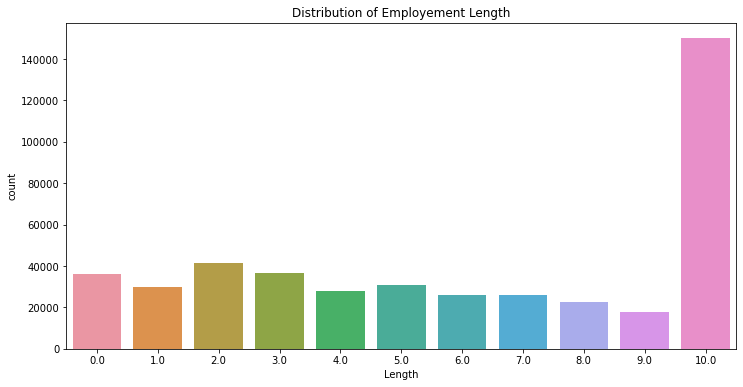

In [130]:
plt.figure(figsize=(12,6))
sns.countplot(loan_data['emp_length'])
plt.xlabel("Length")
plt.title("Distribution of Employement Length")
plt.show()

Well, it can be seen that people who have worked for 10 or more years are more likely to take loans

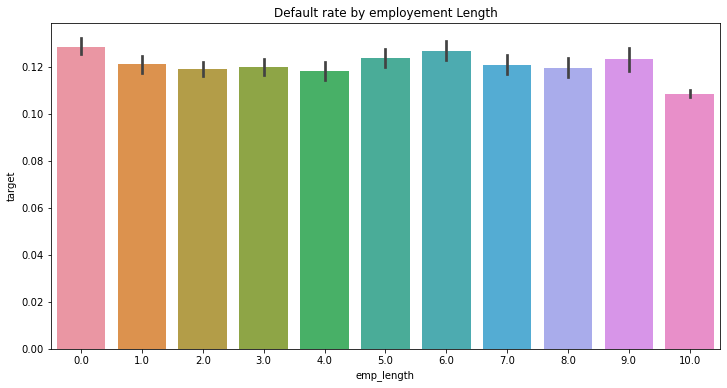

In [131]:
plt.figure(figsize=(12,6))
sns.barplot(x='emp_length',  y ='target', data = loan_data);
plt.title('Default rate by employement Length');

#### Check sub grade 

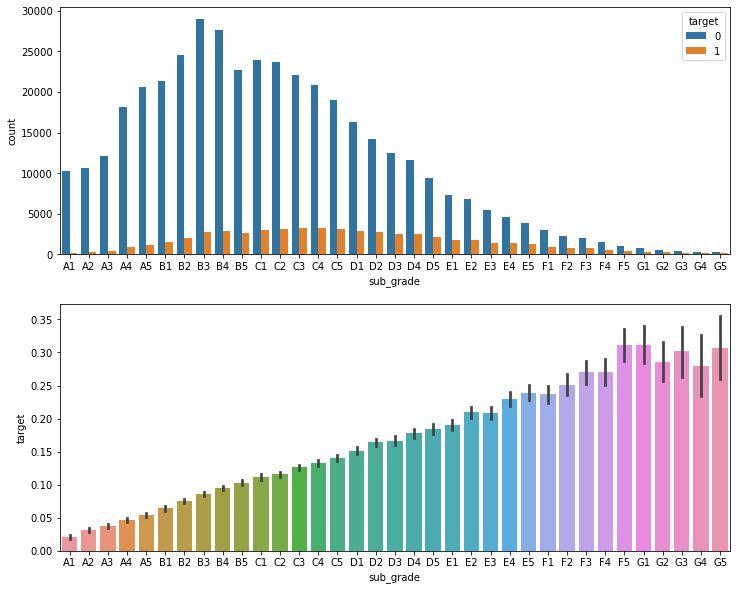

In [132]:
level_order = sorted(list(loan_data['sub_grade'].dropna().unique()))
plt.figure(figsize=(12,10))
plt.subplot(211)
sns.countplot(data = loan_data, x = 'sub_grade', order=level_order, hue = 'target');
plt.title('')
plt.subplot(212)
sns.barplot(data = loan_data, x='sub_grade', order=level_order, y ='target');

Majority of borrowers are from grade A-D, and borrowers with deteriorated grade show higher default risk.

#### Compare corrleated variables   
loan amount and funded amount   
total payment and total payment invested

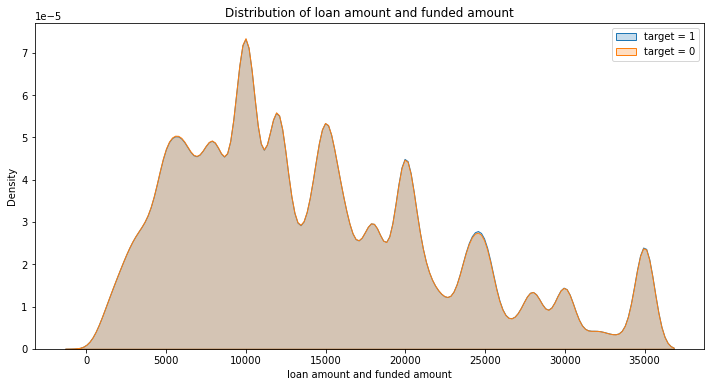

In [133]:
fig = plt.figure(figsize=(12,6))
sns.kdeplot(loan_data.loan_amnt, label = 'target = 1', shade=True)
sns.kdeplot(loan_data.funded_amnt, label = 'target = 0', shade=True);
plt.legend()
plt.xlabel('loan amount and funded amount')
plt.ylabel('Density')
plt.title('Distribution of loan amount and funded amount');

## Transform characteristics and categorical variables into numeric

#### Handle missing values

In [134]:
# Fileter columns with missing values
nacols = loan_data.isnull().sum()
nacols[nacols.values >0]

emp_length                      21008
annual_inc                          4
delinq_2yrs                        29
inq_last_6mths                     29
mths_since_last_delinq         250351
mths_since_last_record         403647
open_acc                           29
pub_rec                            29
revol_util                        340
total_acc                          29
next_pymnt_d                   227214
collections_12_mths_ex_med        145
mths_since_last_major_derog    367311
acc_now_delinq                     29
tot_coll_amt                    70276
tot_cur_bal                     70276
total_rev_hi_lim                70276
dtype: int64

In [135]:
print('There are', len(nacols[nacols.values >0]), 'columns with missing values and we will deal each case by case.')

There are 17 columns with missing values and we will deal each case by case.


In [136]:
# The missing value here means the account never delinquent before, so I convert the coolumn to binary.
loan_data['ever_delq'] = np.where(loan_data['mths_since_last_delinq'].isnull(), 0, 1)

loan_data.drop(columns=['mths_since_last_delinq'], inplace = True)

In [138]:
# Follow business logic, I will fill missing values with zeros for the below columns.
fill0_list = ['emp_length', 'delinq_2yrs', 'inq_last_6mths', 
              'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq',
            'revol_util', 'collections_12_mths_ex_med' ]
loan_data[fill0_list] = loan_data[fill0_list].fillna(0)

In [139]:
# I didn't predict annual_inc using other attibutes due to time contraints. 
# For this column, it's reasonable to fill with median income. 
loan_data['annual_inc'] = loan_data['annual_inc'].replace(np.nan, loan_data['annual_inc'].median())

In [140]:
# Check missing again
loan_data.isnull().sum().sum()

1209000

#### Transform object variables into numeric

In [141]:
loan_data.select_dtypes(include = 'object').nunique()

sub_grade                  35
home_ownership              6
verification_status         3
pymnt_plan                  2
url                    466285
purpose                    14
addr_state                 50
initial_list_status         2
next_pymnt_d              100
dtype: int64

For sub_grade column, I will keep it order and convert it to numeric value since each sub grade has different impact on default rate.

In [142]:
dict_grd = {grad: i+1 for i,grad in enumerate(sorted(loan_data['sub_grade'].unique()))}
loan_data['sub_grade'] = loan_data['sub_grade'].map(dict_grd)

 Perform one-hot encoding on the rest variables

In [143]:
onehot_list = list(loan_data.select_dtypes(include = 'object'))
df_loan = pd.get_dummies(loan_data, columns = onehot_list, prefix = onehot_list)
df = df_loan.copy()

MemoryError: Unable to allocate 202. GiB for an array with shape (466285, 466285) and data type uint8

A common convention after one-hot encoding is to remove one of the one-hot encoded columns from each categorical feature. This convention is only required when creating an OLS model with the normal equation. Since we are use xgboost models here, we will keep all columns.

In [144]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,target,ever_delq,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,5000.0,5000.0,4975.0,36.0,0.1065,162.87,7,10.0,24000.0,27.65,0.0,1.0,3.0,0.0,13648.0,0.837,9.0,863.16,171.62,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,2500.0,60.0,0.1527,59.83,14,0.0,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,0.094,4.0,435.17,119.66,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,2400.0,2400.0,36.0,0.1596,84.33,15,10.0,12252.0,8.72,0.0,2.0,2.0,0.0,2956.0,0.985,10.0,605.67,649.91,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,10000.0,36.0,0.1349,339.31,11,10.0,49200.0,20.00,0.0,1.0,10.0,0.0,5598.0,0.210,37.0,2214.92,357.48,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3000.0,3000.0,3000.0,60.0,0.1269,67.79,10,1.0,80000.0,17.94,0.0,0.0,15.0,0.0,27783.0,0.539,38.0,1066.91,67.30,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


As illustraed in EDA step, some variables are highly correlated (such as, 'loan_amnt' and 'funded_amnt', 'total_pymnt' and 'total_pymnt_inv'). Since ensemble of tree models is able to learn when some features are (highly or perfectly) correlated.
So I will let xgboost model takes care of it.


## Modeling - xgboost

Prepare model input and output and split train and test set

In [ ]:
X = df.drop(columns ='target')
y = df[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123, stratify  = y)

To handle unbalanced classes, I use scale_pos_weight parameters to control the balance of positive and negative weights.
A typical value to consider: sum(negative instances) / sum(positive instances).

In [ ]:
cls_weit = df.target.value_counts()[0]/df.target.value_counts()[1]

#### Train the first modeel

In [ ]:
def model(xtrain, ytrain, xtest):
    model = XGBClassifier(scale_pos_weight = cls_weit)
    model.fit(xtrain, ytrain)
    predictions = model.predict(xtest)
    probs = model.predict_proba(xtest)
    return predictions, probs

In [ ]:
model = XGBClassifier(scale_pos_weight = cls_weit)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probs = model.predict_proba(X_test)

In [ ]:
def perf(y_test, predictions, probs):
    # Performance metrics: Acuracy, Confusion Matrix, AUC score

    print("Acuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))

    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    print("AUC score: %.2f" % (roc_auc))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))    

In [ ]:
accuracies = []
aucs = []
num_features = []
best_accuracy = 0
best_auc = 0
best_num_features_acc = 0
best_num_features_auc = 0

In [ ]:
# Fit model using each importance as a threshold
thresholds = np.unique(np.sort(model.feature_importances_))[::10]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test,predictions)
    roc_auc = auc(fpr, tpr)    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, AUC score: %.2f" % (thresh, select_X_train.shape[1], accuracy*100.0, roc_auc))
    
    # Record results for plotting at the end
    accuracies.append(accuracy)
    aucs.append(roc_auc)
    num_features.append(select_X_train.shape[1])
    selected_features = selection_model.get_booster().feature_names
    # Record best results for plotting at the end
    if accuracy > best_accuracy:
        best_accuracy, best_num_features_acc = accuracy, len(selected_features)
    if roc_auc > best_auc:
        best_auc, best_num_features_auc, fprs, tprs = roc_auc, len(selected_features), fpr, tpr

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=num_features, y=accuracies).set_title('Num. Features vs. Accuracies');

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=num_features, y=aucs).set_title('Num. Features vs. ROC AUCs');

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fprs, tprs, 'b', label = 'AUC = %0.2f' % best_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1])
plt.ylim([-0.1, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
num_features = 40
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances*-1)
indices = indices[0:num_features]
_ = plt.figure(figsize=(16,7))
_ = plt.title('XGBoost: Most Important Features')
_ = plt.bar(range(len(indices)), importances[indices], color='steelblue')
_ = plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=85, fontsize = 14)
_ = plt.ylabel('Relative Importance')
_ = plt.xlim(-1,num_features-1)
_ = plt.tight_layout()
# # _ = plt.savefig('features.png',dpi=100)

In [ ]:
# plt.barh(df.columns[sorted_idx][-15:], model.feature_importances_[sorted_idx][-15:])
# plt.xlabel("Xgboost Feature Importance")

num_features = 40
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances*-1)[0:num_features][::-1]
_ = plt.figure(figsize=(8,10))
_ = plt.title('XGBoost: Most Important Features')
_ = plt.barh(range(len(indices)), importances[indices], color='steelblue')
_ = plt.yticks(range(len(indices)), [features[i] for i in indices],  fontsize = 10)
_ = plt.ylabel('Relative Importance')
# _ = plt.ylim(-1,num_features-1)
# _ = plt.tight_layout()


In [ ]:
#Record results
thresholds = np.unique(np.sort(model.feature_importances_))
accuracies = []
aucs = []
fprs = None
tprs = None
num_features = []
best_accuracy = 0
best_auc = 0
best_num_features_acc = 0
best_num_features_auc = 0

In [ ]:
df.inq_last_6mths.describe()

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/